# Developing a Customer Churn Prediction Model for a Bank

## Contents <a id='back'></a>
* [1. Introduction](#intro)
* [2. Data Exploration](#data_exploration)
* [3. Data Preprocessing](#data_preprocessing)
* [4. Exploratory Data Analysis (EDA)](#eda)
    * [4.1 Distributions of the Numerical Features Data](#numerical_eda)
    * [4.2 Distributions of the Numerical Features Data Per Target Class](#numerical_target_eda)
    * [4.3 Distributions of the Categorical Features Data based on Target Classes](#categorical_target_eda)
    * [4.4 Distribution of the Target Classes](#target_eda)
* [5. Feature Engineering](#feature)
* [6. Development and Fine Tuning of Different Models](#models)
    * [6.1 Without Resampling](#without_resampling)
    * [6.2 Class Weight Adjustment](#class_weight)
    * [6.3 Upsampling (Oversampling)](#upsampling)
    * [6.4 Downsampling (Undersampling)](#downsampling)
    * [6.5 Resampling by a Combination of Upsampling and Downsampling (SMOTETomek)](#smotetomek)
* [7. Final Model Selection and Evaluation](#final_model)
    * [7.1 Threshold Adjustment](#threshold)
    * [7.2 F1-score, Precision and Recall](#metrics)
    * [7.3 ROC Curve and AUC-ROC Score](#auc_roc)
* [8. General Conclusion](#general_conclusion)

## 1. Introduction <a id='intro'></a>

The customers of Beta Bank are leaving little by little every month. The bankers figured out that it is more cost-effective to retain the existing customers rather than attract new ones. This project aims to build a model to predict whether a customer will leave the bank soon.

### Purpose
To develop a binary classification model which analyses the data on customers' past behaviour and termination of contracts to identify potential leaving customers. **The f1-score of the model has to be 59% and above as requested by Beta Bank.**

[Back to Contents](#back)

---

In [1]:
# For data preprocessing and manipulation
import pandas as pd
import numpy as np
import re
import inspect
import time
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.utils import resample, shuffle
from imblearn.combine import SMOTETomek

# For visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Machine learning models
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

# For model evaluation
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score

## 2. Data Exploration <a id='data_exploration'></a>

In [2]:
# Load dataset
try:
    data = pd.read_csv('Churn.csv')
except:
    data = pd.read_csv('/datasets/Churn.csv')

In [3]:
# Have a look at the dataset
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


The dataset has 10000 rows (customers) and 14 columns of information related to each customer.

**Description of data**

*Features*
- RowNumber — data string index
- CustomerId — unique customer identifier
- Surname — surname
- CreditScore — credit score
- Geography — country of residence
- Gender — gender
- Age — age
- Tenure — period of maturation for a customer’s fixed deposit (years)
- Balance — account balance
- NumOfProducts — number of banking products used by the customer
- HasCrCard — customer has a credit card
- IsActiveMember — customer’s activeness
- EstimatedSalary — estimated salary

*Target*
- Exited — сustomer has left

**Issues need to be addressed**

- The `RowNumber`, `CustomerId` and `Surname` features provide no information in predicting potential leaving customers and thus will be dropped. 
- The categorical features `Geography` and `Gender` will be transformed into numerical features before model development. 
- The column names will also be renamed by using the snake case convention. 

In [4]:
# Check for duplicates
data.duplicated().sum()

0

In [5]:
# Check the data types
data.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [6]:
# Check if there is any missing value
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

The dataset has no duplicates and the data types are all correct except the `Tenure` column. 

**Issues need to be addressed**

- The `Tenure` column has 909 missing values and the data type will be converted to `int64` after dealing with the missing values.

In [7]:
# Look at the statictics of the numerical columns
data.drop(columns=['RowNumber', 'CustomerId']).describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


For the numerical features, there are no obvious outliers and anomalies.

**Issues need to be addressed**

- The ranges of the values of the numerical features are of different scales and feature scaling will be applied. The reason are as follows:
    1. Feature scaling is needed for distance-based algorithms like KNN so that the machine learing algorithms treat these numerical features with equal importance.
    2. For algorithms like xgboost which uses gradient descent for optimisation, feature scaling improve the convergence speed.
    3. Some algorithms like logistic regression will fail or hard to converge without feature scaling.
    4. Feature scaling does not affect the algorithms which do not require it, such as tree-based algorithms.
    
[Back to Contents](#back)

## 3. Data Preprocessing <a id='data_preprocessing'></a>

In [8]:
# Rename the column names with snake case convention
data.columns = [re.sub('([A-Z])', r' \1', column).lower().strip().replace(' ', '_') for column in data.columns]

In [9]:
# Drop the unnecessary features row_number, customer_id and surname
data = data.drop(columns=['row_number', 'customer_id', 'surname'])

In [10]:
# Have a look at the dataset
data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### Missing Values <a id='missing_values'></a>

In [11]:
# Create a dataframe containing only the rows with missing values in tenure
tenure_na = data.query('tenure.isna()')

In [12]:
# Calculate the number and percentage of missing data.
print('The number of missing values in tenure: ', end='')
print(f'{tenure_na.shape[0]}')
print('The percentage of missing values in tenure: ', end='')
print(f'{tenure_na.shape[0] / data.shape[0]:.2%}')

The number of missing values in tenure: 909
The percentage of missing values in tenure: 9.09%


With 10% of missing data, we should consider to fill the missing data to preservse the valuable information in the other columns. Let's compare the distributions of the original data and the tenure_na data to see if the missingness has any pattern.

In [13]:
# Compare the distribution of the numerical data of original data and tenure_na
display(data.describe())
display(tenure_na.describe())

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,909.000000,909.000000,0.0,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000
mean,648.451045,38.647965,NaN,76117.341474,1.530253,0.710671,0.510451,99180.389373,0.201320
std,99.079381,9.785438,NaN,63105.690715,0.588452,0.453701,0.500166,56378.063765,0.401207
min,359.000000,18.000000,NaN,0.000000,1.000000,0.000000,0.000000,106.670000,0.000000
25%,580.000000,32.000000,NaN,0.000000,1.000000,0.000000,0.000000,49872.330000,0.000000
50%,647.000000,37.000000,NaN,96674.550000,1.000000,1.000000,1.000000,99444.020000,0.000000
75%,718.000000,43.000000,NaN,128554.980000,2.000000,1.000000,1.000000,145759.700000,0.000000
max,850.000000,92.000000,NaN,206663.750000,4.000000,1.000000,1.000000,199390.450000,1.000000


For the numerical columns, the distributions of the original data and the tenure_na data are similar. The missing values in `tenure` do not show any pattern.

In [14]:
# Compare the distribution of the categorical data of original data and tenure_na
display(pd.concat(
    [data['geography'].value_counts(normalize=True), 
     tenure_na['geography'].value_counts(normalize=True)],
    axis=1, keys=['original_data', 'tenure_na']
).reset_index())
        
display(pd.concat(
    [data['gender'].value_counts(normalize=True), 
     tenure_na['gender'].value_counts(normalize=True)],
    axis=1, keys=['original_data', 'tenure_na']
).reset_index())

,geography,original_data,tenure_na
0,France,0.5014,0.510451
1,Germany,0.2509,0.237624
2,Spain,0.2477,0.251925


,gender,original_data,tenure_na
0,Male,0.5457,0.531353
1,Female,0.4543,0.468647


In categorical columns, both datasets have almost identical distributions. Therefore, we can conclude that the missing values in `tenure` shows no pattern and assume the data is missing completely at random **(MCAR)**. Next, we will check the distribution of the tenure data before deciding the method to fill the missing data.

In [15]:
# Check the distribution of data in the tenure column
data['tenure'].value_counts(normalize=True).to_frame().sort_index()

,proportion
tenure,
0.0,0.042020
1.0,0.104719
2.0,0.104499
3.0,0.102079
4.0,0.097349
5.0,0.101969
6.0,0.096909
7.0,0.101749
8.0,0.102629


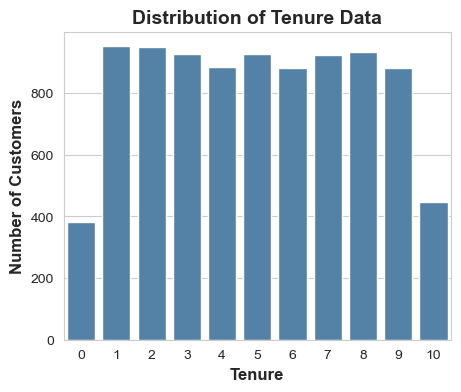

In [16]:
# Plot a bar chart to show the distribution of data in the tenure column
sns.set_style('whitegrid')
plt.figure(figsize=(5,4))

sns.countplot(x=data['tenure'], color='steelblue')
plt.title('Distribution of Tenure Data', fontsize=14, fontweight='bold')
plt.xlabel('Tenure', fontsize=12, fontweight='bold')
plt.ylabel('Number of Customers', fontsize=12, fontweight='bold')
plt.xticks([x for x in range(11)], [x for x in range(11)])

plt.show()

The data is uniformly distributed except for the `0` and the `10` values. It will be inappropriate to fill the missing data with the mean, median or mode as it will distort the data distribution. To maintain the distribution, the data will be filled with the random samples based on the relative frequencies.

In [17]:
# Generate random samples based on the relative frequencies
na_count = data['tenure'].isna().sum()
choices = data['tenure'].value_counts().index
prob = data['tenure'].value_counts(normalize=True).values

generator = np.random.Generator(np.random.PCG64(12345))
random_samples = generator.choice(a=choices, size=na_count, p=prob)

In [18]:
# Create a new column to check the distribution of data after filling the random samples
data['tenure_temp'] = data['tenure']
data.loc[data['tenure_temp'].isna(), 'tenure_temp'] = random_samples

In [19]:
# Compare the distributions of data in tenure and tenure_temp
pd.concat(
    [data['tenure'].value_counts(normalize=True).sort_index(),
     data['tenure_temp'].value_counts(normalize=True).sort_index()],
     axis=1, keys=['tenure', 'tenure_temp']
)

,tenure,tenure_temp
0.0,0.042020,0.0419
1.0,0.104719,0.1038
2.0,0.104499,0.1048
3.0,0.102079,0.1027
4.0,0.097349,0.0968
5.0,0.101969,0.1025
6.0,0.096909,0.0962
7.0,0.101749,0.1016
8.0,0.102629,0.1042
9.0,0.097019,0.0969


The table shows that the distribution of the tenure data is similar to that of the tenure_temp data after filling the missing values.

In [20]:
# Fill the missing values in tenure with random samples
data.loc[data['tenure'].isna(), 'tenure'] = random_samples

In [21]:
# Change the data type of tenure to int64
data['tenure'] = data['tenure'].astype('int64')

In [22]:
# Drop the tenure_temp column
data = data.drop(columns=['tenure_temp'])

In [23]:
# Check the data types
data.dtypes

credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

In [24]:
# Final check on the missing values
data.isna().sum()

credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

[Back to Contents](#back)

## 4. Exploratory Data Analysis (EDA) <a id='eda'></a>

---

The following function is created to automate the task in this and later stage.

In [25]:
def target_classes_dist(target):
    '''
    This function calculate the number and percentage of each target class
    and plot a countplot to show the distribution of target classes
    '''
    # Plot a countplot to show the distribution
    sns.set_style('whitegrid')
    plt.figure(figsize=(4,3))
    
    sns.countplot(x=target, width=0.5, palette=['steelblue', 'tomato'])
    plt.title('Distribution of Target Classes', fontsize=14, fontweight='bold')
    plt.xlabel('Exited', fontsize=12)
    plt.ylabel('Number of Customers', fontsize=12)
    plt.show()
    
    # Calculate the proportion of each class
    class_0 = target.value_counts()[0]
    class_1 = target.value_counts()[1]
    class_total = class_0 + class_1
    
    print('Samples of class 0:', class_0)
    print('Samples of class 1:', class_1)
    print('-' * 50)
    print('Percentage of class 0:', f'{class_0 / class_total:.2%}')
    print('Percentage of class 1:', f'{class_1 / class_total:.2%}')
    print('-' * 50)
    print('\033[1m')
    print('The ratio of 0 to 1 is', f'{class_0 / class_1:.2f}')
    print('\033[0m')

---

### 4.1 Distributions of the Numerical Features Data <a id='numerical_eda'></a>

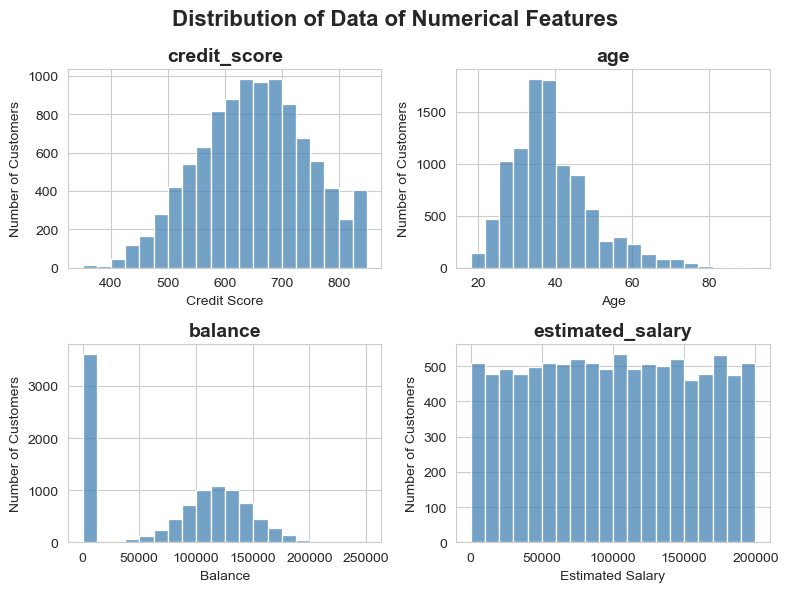

In [26]:
# Plot histograms to show the distribution of numerical features data
numerical_features = ['credit_score', 'age', 'balance', 'estimated_salary']

sns.set_style('whitegrid')
fig, axs = plt.subplots(2, 2, figsize=(8,6))

plt.suptitle('Distribution of Data of Numerical Features', fontsize=16, fontweight='bold')

for i in range(2):
    for j in range(2):
        sns.histplot(x=data[numerical_features[i*2 + j]], bins=20, color='steelblue', ax=axs[i][j])
        axs[i][j].set_title(numerical_features[i*2 + j], fontsize=14, fontweight='bold')
        axs[i][j].set_ylabel('Number of Customers')

axs[0][0].set_xlabel('Credit Score')
axs[0][1].set_xlabel('Age')
axs[1][0].set_xlabel('Balance')
axs[1][1].set_xlabel('Estimated Salary')

plt.tight_layout()
plt.show()

The distribution of data of `credit_score` is slightly left-skewed while the distribution of `age` data is heavily right-skewed. The distribtuion of `balance` data is normal except that there is a huge amount of `0` values. The `estimated salsary` data has a uniform distribtuion.

**Issue to be addressed**

Log transformation will be applied to these two columns to make the data distribution closer to a normal disbution which can be beneficial for certain machine learning models like naive bayes. Besides that, log transformation also reduce the impact of outliers in `credit_score`.

[Back to Contents](#back)

### 4.2 Distributions of the Numerical Features Data Per Target Class <a id='numerical_target_eda'></a>

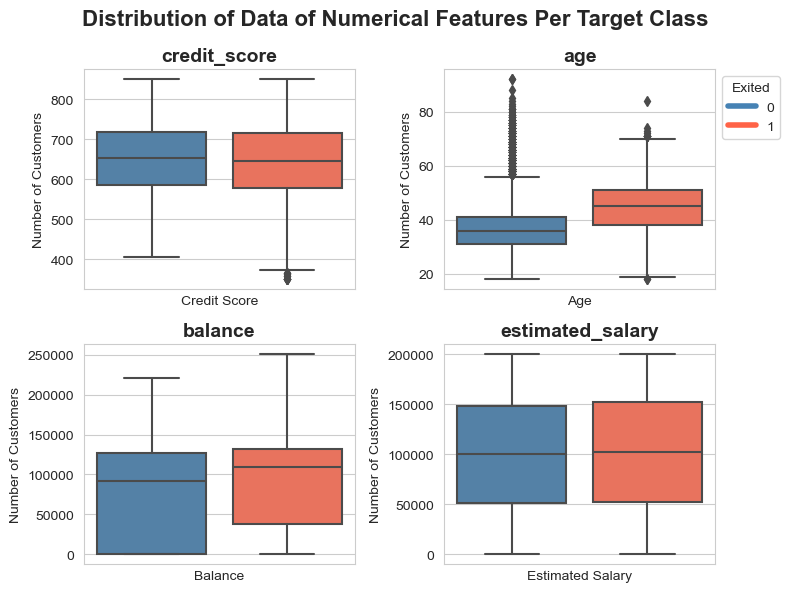

In [27]:
# Plot boxplots to compare the distributions of numerical features per target class
sns.set_style('whitegrid')
fig, axs = plt.subplots(2, 2, figsize=(8,6))

for i in range(2):
    for j in range(2):
        sns.boxplot(data=data, x='exited', y=numerical_features[i*2 + j], 
                    palette=['steelblue', 'tomato'], ax=axs[i][j])        
        axs[i][j].set_title(numerical_features[i*2 + j], fontsize=14, fontweight='bold')
        axs[i][j].set_ylabel('Number of Customers')
        axs[i][j].set_xticks([])

plt.suptitle('Distribution of Data of Numerical Features Per Target Class',
             fontsize=16, fontweight='bold')

axs[0][0].set_xlabel('Credit Score')
axs[0][1].set_xlabel('Age')
axs[1][0].set_xlabel('Balance')
axs[1][1].set_xlabel('Estimated Salary')

legend_labels = ['0', '1']
legend_handles = [Line2D([0], [0], color='steelblue', lw=4), Line2D([0], [0], color='tomato', lw=4)]
axs[0][1].legend(legend_handles, legend_labels, title="Exited", 
                 loc='upper left', bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()

In the histograms of `age` feature, it can be seen that the distribtutions of the `0` category (customers who stay) and `1` category (customers who left) are not the same, this shows that `age` and could be a good indicator for a machine learning model to predict whether a customer will leave.

The distributions of `0` and `1` categories are almost identical for the `credit_score`, `balance` and `estimated_salary` features.

[Back to Contents](#back)

### 4.3 Distributions of the Categorical Features Data based on Target Classes <a id='categorical_target_eda'></a>

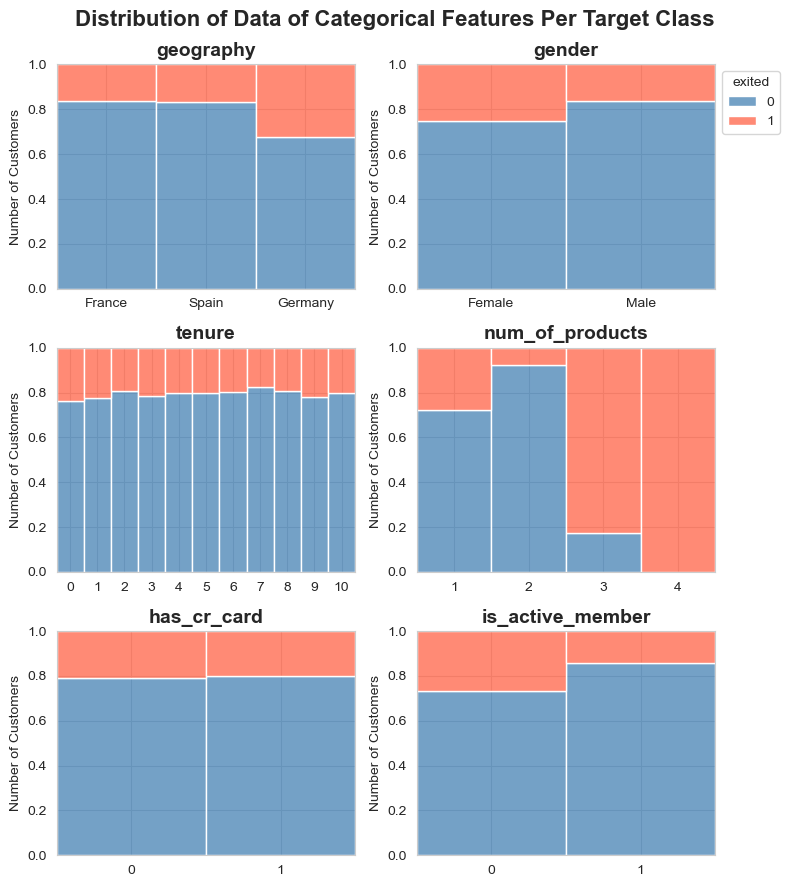

In [28]:
# Plot filled barcharts for the categorical features per target class
categorical_features = ['geography', 'gender', 'tenure', 'num_of_products', 'has_cr_card',
                       'is_active_member']

sns.set_style('whitegrid')
fig, axs = plt.subplots(3, 2, figsize=(8,9))

for i in range(3):
    for j in range(2):
        sns.histplot(data=data, x=str(categorical_features[i*2 + j]), hue='exited', hue_order=[1, 0],
                     multiple='fill', palette=['tomato', 'steelblue'], discrete=True, ax=axs[i][j])
        axs[i][j].set_title(categorical_features[i*2 + j], fontsize=14, fontweight='bold')
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('Number of Customers')
        if (i*2 + j) != 1:
            axs[i][j].get_legend().remove()
        else:
            axs[i][j].legend(title='exited', labels=[0, 1], loc='upper left', bbox_to_anchor=(1,1))

plt.suptitle('Distribution of Data of Categorical Features Per Target Class',
             fontsize=16, fontweight='bold')

axs[1][0].set_xticks([x for x in range(11)], [x for x in range(11)])
axs[1][1].set_xticks([x for x in range(1,5)], [x for x in range(1,5)])
axs[2][0].set_xticks([0, 1], [0, 1])
axs[2][1].set_xticks([0, 1], [0, 1])

plt.tight_layout()
plt.show()

From the overview of the filled barcharts, all the six categorical features except `tenure` and `has_cr_card` are potential predictors of churtomer churn. The following summarises the categories which are more likely to have customer churn.
- `geography`: Germany
- `gender`: Female
- `num_of_products`: 3 and 4
- `is_active_member`: 0

[Back to Contents](#back)

### 4.4 Distribution of the Target Classes <a id='target_eda'></a>

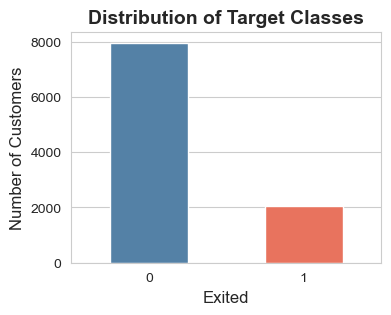

Samples of class 0: 7963
Samples of class 1: 2037
--------------------------------------------------
Percentage of class 0: 79.63%
Percentage of class 1: 20.37%
--------------------------------------------------

The ratio of 0 to 1 is 3.91



In [29]:
# Show the distribution of the target classes
target_classes_dist(data['exited'])

The distribution of the target classes is imbalanced, with the ratio of the `0` class to the `1` class being approximately 80:20. Most machine learning algorithms perform better when there is an almost equal number of samples in both the classes. In an imbalanced classification, the models tend to bias towards the majority class and this leads to a poor predictive performance. To address on the imbalanced classification issue, there are mainly three approaches:
1. Data approach: Upsampling or downsampling the original data.
2. Algorithm approach: Boosting and bagging are two popular ensemble methods to deal with imbalanced data.
3. Hybrid approach

[Back to Contents](#back)

## 5. Feature Engineering <a id='feature'></a>

### 5.1 Label Encoding

Since we will only train tree based model in this project, the `geography` feature will be transform to numerical feature with label encoder.

In [30]:
# Perform ordinal encoding on the geography feature
oc = OrdinalEncoder()
data['geography'] = oc.fit_transform(data['geography'].values.reshape(-1,1))

### 5.2 One-Hot Encoding

The `gender` feature will be transformed by one-hot encoder.

In [31]:
# Perform one-hot encoding on the gender feature
# Drop one fo the columns to avoid dummy variable trap
data_ohe = pd.get_dummies(data, drop_first=True)

### 5.3 Log Transformation

Many machine learning models (such as logistic regression, catboost, etc.) use gradient descent algorithm to optimise the loss function. To make the algorithm converge faster and easier, log transformation will be applied on the `credit_score` and `age` features to make the distribution more symmetric and closer to a normal distribution.

In [32]:
# Perform log transformation on the credit_score and age features
data_ohe['log_credit_score'] = np.log(data_ohe['credit_score'])
data_ohe['log_age'] = np.log(data_ohe['age'])

In [33]:
# Have a look at the first five rows of data_ohe
data_ohe.head()

,credit_score,geography,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,gender_Male,log_credit_score,log_age
0,619,0.0,42,2,0.00,1,1,1,101348.88,1,False,6.428105,3.737670
1,608,2.0,41,1,83807.86,1,0,1,112542.58,0,False,6.410175,3.713572
2,502,0.0,42,8,159660.80,3,1,0,113931.57,1,False,6.218600,3.737670
3,699,0.0,39,1,0.00,2,0,0,93826.63,0,False,6.549651,3.663562
4,850,2.0,43,2,125510.82,1,1,1,79084.10,0,False,6.745236,3.761200


### 5.4 Feature Scaling

All the numerical features will also be scaled by standardisation to make the range of the values are on the same scale. This will further improve the convergence speed of the gradient descent algorithm.

In [34]:
# Set up the feature variable X and the target variable y
X = data_ohe.drop(columns=['credit_score', 'age', 'exited'])
y = data_ohe['exited']

# Check the shape of X and y
X.shape, y.shape

((10000, 10), (10000,))

In [35]:
# Separate the data into training set, validation set and test set
# train:valid:test = 70:15:15
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=12345)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=3/17, random_state=12345)

In [36]:
# Check the percentage of each variable in all the three sets
print('Percentage of X_train:', f'{X_train.shape[0] / X.shape[0]:.0%}')
print('Percentage of y_train:', f'{y_train.shape[0] / y.shape[0]:.0%}')
print('Percentage of X_val:', f'{X_val.shape[0] / X.shape[0]:.0%}')
print('Percentage of y_val:', f'{y_val.shape[0] / y.shape[0]:.0%}')
print('Percentage of X_test:', f'{X_test.shape[0] / X.shape[0]:.0%}')
print('Percentage of y_test:', f'{y_test.shape[0] / y.shape[0]:.0%}')

Percentage of X_train: 70%
Percentage of y_train: 70%
Percentage of X_val: 15%
Percentage of y_val: 15%
Percentage of X_test: 15%
Percentage of y_test: 15%


In [37]:
# Check the shape of each variable in all the three sets
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of y_val:', y_val.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (7000, 10)
Shape of y_train: (7000,)
Shape of X_val: (1500, 10)
Shape of y_val: (1500,)
Shape of X_test: (1500, 10)
Shape of y_test: (1500,)


In [38]:
# Perform feature scaling on the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

[Back to Contents](#back)

## 6. Development and Fine Tuning of Different Models <a id='models'></a>

---

The following functions will be used to automate the tasks in this section.

In [39]:
def model_score(model, X, y, threshold=None):
    '''
    This function evaluates the model performance by using the
    accuracy, f1-score, precision and recall
    This function also plots the confusion matrix
    '''
    # Print the model information
    print('\033[1m', model, '\033[1m')
    
    if threshold is None:
        y_pred = model.predict(X)
    else:
        y_pred = (model.predict_proba(X)[:,1] >= threshold).astype(int)    
    
    # Plot the confusion matrix    
    cm = confusion_matrix(y, y_pred)
    
    sns.set_style('white')
    plt.figure(figsize=(2.5,2.5))
    
    sns.heatmap(cm, annot=True, square=True, fmt='d', cbar=False, 
                cmap='Reds', linecolor='black', linewidth=1)
    plt.title('Confusion Matrix', fontsize=13, fontweight='bold')
    plt.xlabel('Predicted Values', fontsize=11, fontweight='bold')
    plt.ylabel('Actual Values', fontsize=11, fontweight='bold')
    plt.xticks(ticks=[0.5, 1.5], labels=['False', 'True'])
    plt.yticks(ticks=[0.5, 1.5], labels=['False', 'True'])
    
    plt.show()
    
    # Print the different metric scores    
    print('\033[1m')
    print('F1-score:', f'{f1_score(y, y_pred):.2%}')
    print('Accuracy:', f'{accuracy_score(y, y_pred):.2%}')    
    print('Precision:', f'{precision_score(y, y_pred, zero_division=0):.2%}')
    print('Recall:', f'{recall_score(y, y_pred):.2%}')
    print('\033[0m')  

In [40]:
def custom_GridSearch(X_train, y_train, X_val, y_val, estimator, param_grid):
    """
    This function is a simplified version of GridSearchCV() function
    which does not use cross-validation method to find the best f1-score
    This function returns a dataframe containing result of each model
    and the best model with the highest accuracy score
    """
    start_time = time.time()
    
    # Declare the variables needed to store the relevant information  
    model_param_list = []
    f1_score_list = []
    accuracy_list = []
    best_model = {}
    best_model_data = {'class_0': y_train.value_counts()[0], 'class_1': y_train.value_counts()[1],
                       'hyperparameters': None, 'f1_score': 0, 'accuracy': 0}    
    
    # Grid search the best model
    for hyperparams in param_grid:
        for param_value in product(*hyperparams.values()):
            model_param = {key: value for key, value in zip(hyperparams.keys(), param_value)}
            
            # Check if the estimator accepts the random_state parameter
            if 'random_state' in inspect.signature(estimator).parameters:
                model = estimator(**model_param, random_state=12345)
            else:
                model = estimator(**model_param)
            
            # Train the model and find the relevant metrics
            model.fit(X_train, y_train)                
            y_pred = model.predict(X_val)
            f1 = f1_score(y_val, y_pred)
            accuracy = accuracy_score(y_val, y_pred)            
            
            # Store the information
            model_param_list.append(model_param)
            f1_score_list.append(f1)
            accuracy_list.append(accuracy)
            
            # Update the best model and relevant information
            if f1 > best_model_data['f1_score']:
                best_model = model
                best_model_data['hyperparameters'] = model_param
                best_model_data['f1_score'] = f1
                best_model_data['accuracy'] = accuracy           
    
    # Create a dataframe to store the search result
    search_result = pd.DataFrame({'params': model_param_list, 
                                  'f1_score': f1_score_list, 
                                  'accuracy': accuracy_list})
    search_result = pd.concat([pd.json_normalize(search_result['params'], max_level=0), 
                               search_result[['f1_score', 'accuracy']]],
                              axis=1)    
    search_result = search_result.sort_values('f1_score', ascending=False).reset_index(drop=True)
    
    end_time = time.time()
    
    # Print the time taken
    time_taken = end_time - start_time
    minute = int(time_taken / 60)
    second = round(time_taken - minute * 60)
    if minute <= 1:
        print('Time taken:', f'{minute} minute {second} seconds')
    else:
        print('Time taken:', f'{minute} minutes {second} seconds')
    
    # return the result
    return search_result, best_model, best_model_data

In [41]:
def sampling(X, y, sampling_method, sampling_strategy):
    '''
    This function is a simplied version of RandomOverSampler
    and RandomUnderSampler in imblearn library
    The strategy parameter is the ratio of minority class to majority class
    '''
    # Determine the majority and minority classes
    if y[y == 0].shape[0] > y[y == 1].shape[0]:
        X_major = X[y == 0]
        X_minor = X[y == 1]
        y_major = y[y == 0]
        y_minor = y[y == 1]
    else:
        X_major = X[y == 1]
        X_minor = X[y == 0]
        y_major = y[y == 1]
        y_minor = y[y == 0]    
        
    # Up or down sampling
    if sampling_method == 'up':
        # Calculate the upsampling size
        up_size = round(y_major.shape[0] * sampling_strategy)
        
        # Upsampling the minority X and y
        if up_size < y_minor.shape[0]:
            print('Error! Please check the sampling method and the strategy again.')
        else:
            X_minor, y_minor = resample(X_minor, y_minor, 
                                        n_samples = up_size, 
                                        replace = True,
                                        random_state = 12345)            
    elif sampling_method == 'down':
        # Calculate the downsampling size
        down_size = round(y_minor.shape[0] / sampling_strategy)
        
        if down_size > y_major.shape[0]:
            print('Error! Please check the sampling method and the strategy again.')
        else:
            X_major, y_major = resample(X_major, y_major,
                                        n_samples = down_size,
                                        replace = False,
                                        random_state=12345)    
    else:
        print('Error! Please check the sampling method and the strategy again.')
    
    # Create the X and y after sampling
    X_sampling = pd.concat([pd.DataFrame(X_major), pd.DataFrame(X_minor)])
    y_sampling = pd.concat([pd.Series(y_major), pd.Series(y_minor)])
    
    # return X and y
    return shuffle(X_sampling, y_sampling, random_state=12345)

---

#### Baseline Model

In [42]:
# Create a baseline model which always predict the majority class
base_model = DummyClassifier(strategy='most_frequent')
base_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

 DummyClassifier(strategy='most_frequent') 


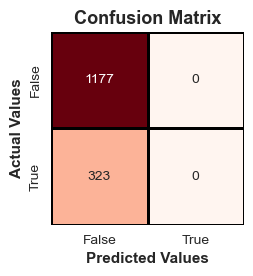


F1-score: 0.00%
Accuracy: 78.47%
Precision: 0.00%
Recall: 0.00%



In [43]:
# Evaluate the baseline model
model_score(base_model, X_val, y_val)

The baseline model predicts the most frequent class which is `0` in this case. The model has a good accuracy score of 78.47% but 0% in f1-score, precision rate and recall rate.

To understand why the precision and recall is 0%, we can look at the two formulae:

$$\begin{align*}
\textrm{Precision} &= \frac{\textrm{TP}}{\textrm{TP} + \textrm{FP}} \tag{1} \\
\textrm{Recall} &= \frac{\textrm{TP}}{\textrm{TP} + \textrm{FN}} \tag{2}
\end{align*}$$

Since there is no `1` prediction from the baseline model, the count of `TP` is zero, therefore the precision and the recall will be 0%. (Note: For the calculation of precision, the result of 0/0 is manually set to 0 since `FP` count is also 0
)

How about the f1-score? It is the harmonic mean of the precision and recall, let's look at the formula again:

$$\begin{align*}
\textrm{F1} &= \frac{2}{\frac{1}{\textrm{Precision}} + \frac{1}{\textrm{Recall}}} \tag{3}
\end{align*}$$

Substituting (1) and (2) into (3), we have

$$\begin{align*}
\textrm{F1} = \frac{2\textrm{TP}}{2\textrm{TP} + \textrm{FP} + \textrm{FN}} \tag{4}
\end{align*}$$

From (4), the f1-score will also be 0% as the `TP` count is 0. To maximise the f1-score,  the `TP` count in the numerator should be maximise while the `FP` and `FN` counts in the denominator should be minimised. On contrast, the accuracy score is calculated by

$$\begin{align*}
\textrm{Accuracy} = \frac{\textrm{TP} + \textrm{TN}}{\textrm{All Predictions}} \tag{5}
\end{align*}$$

For an imbalanced classification, for example, `0` class:`1` class = 99:1, a high accuracy score of 99% can be easily obtained by blindly predicting `0`. Therefore, f1-score is a better evaluation metric in this case as it takes the `FP` and `FN` into account.

As a result, **f1-score will be used as an evaluation metric** in this project.

[Back to Contents](#back)

### 6.1 Without Resampling <a id='without_resampling'></a>

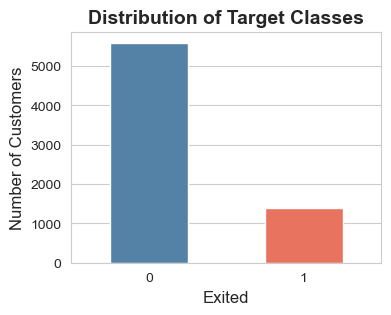

Samples of class 0: 5597
Samples of class 1: 1403
--------------------------------------------------
Percentage of class 0: 79.96%
Percentage of class 1: 20.04%
--------------------------------------------------

The ratio of 0 to 1 is 3.99



In [44]:
# Show the distribution of the target classes in y_train
target_classes_dist(y_train)

In [45]:
# Create a dictionary to store all of the best models
best_model_dict = {}

# Create a dictionary to store the relevant information of best models
best_model_data_dict = {}

In [46]:
# Find the best decision tree without Resampling
dt_hyperparams = [
    {'criterion': ['gini', 'entropy'],
     'max_depth': [x for x in range(6,16)]}
]

dt_result, best_model_dict['Decision Tree'], best_model_data_dict['Decision Tree'] = custom_GridSearch(
    X_train, y_train, X_val, y_val,
    estimator = DecisionTreeClassifier,
    param_grid = dt_hyperparams)

Time taken: 0 minute 1 seconds


In [47]:
# Show the top 5 results
dt_result.head()

,criterion,max_depth,f1_score,accuracy
0,gini,7,0.547529,0.841333
1,gini,8,0.541176,0.844000
2,gini,9,0.534381,0.842000
3,gini,11,0.525939,0.823333
4,gini,12,0.518650,0.819333


 DecisionTreeClassifier(max_depth=7, random_state=12345) 


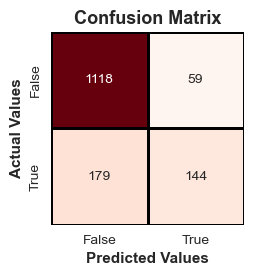


F1-score: 54.75%
Accuracy: 84.13%
Precision: 70.94%
Recall: 44.58%



In [48]:
# Evaluate the best model without resampling
model_score(best_model_dict['Decision Tree'], X_val, y_val)

Without addressing the issuse of imbalanced classes, the best decision tree model performs better than the baseline model with a f1-score of 54.75% and accuracy of 84.13%. However, the low recall rate of 44.58% indicates that the model struggles to identify customers who might leave.

[Back to Contents](#back)

### 6.2 Class Weight Adjustment <a id='class_weight'></a>

By increasing the `class_weight` of the minority class, the model is penalised for misclassifying the minority class. Thus, we can try different `class_weight` to find a better model.

In [49]:
# Calculate the balanced class weight
class_0 = y_train[y_train == 0].shape[0]
class_1 = y_train[y_train == 1].shape[0]
weight_0 = y_train.shape[0] / (2 * class_0)
weight_1 = y_train.shape[0] / (2 * class_1)

print('Balanced Class Weights')
print('Weight of class 0:', weight_0)
print('Weight of class 1:', weight_1)
print('Ratio:', weight_1 / weight_0)

Balanced Class Weights
Weight of class 0: 0.6253350008933357
Weight of class 1: 2.4946543121881684
Ratio: 3.9893086243763367


The ratio of balanced class weights is about 4, we can try other combinations in the grid search process.

#### Decision Tree

The following hyperparameters will be tuned to find a good decision tree model:
- `criterion`: The calculation of `gini` index involves the square of the probability of each class. On the other hand, the calculation of `entropy` involves the product of the probability and the log of the probability of each class. Therefore, it is argued that `entropy` performs better than the `gini` criteria for an imbalanced classification since the log of a lower probability will be scaled up.
- `max_depth`: A low value of `max_depth` may train an underfitting tree model while a high value of `max_depth` might cause the model to be overfitting.
- `class_weight`: By setting a higher value on the minority class, the model will be penalised more for misclassifying the minority class.

In [50]:
# Find the best decision tree by adjusting the hyperparameter class_weight
dt_hyperparams = [
    {'criterion': ['gini', 'entropy'],
     'max_depth': [x for x in range(6,16)],
     'class_weight': ['balanced', {0: 1.0, 1: 2.0}, {0: 1.0, 1: 3.0}]}
]

dt_cw_result, best_model_dict['Decision Tree CW'], best_model_data_dict['Decision Tree CW'] = custom_GridSearch(
    X_train, y_train, X_val, y_val,
    estimator = DecisionTreeClassifier,
    param_grid = dt_hyperparams)

Time taken: 0 minute 4 seconds


In [51]:
# Show the top 10 results
dt_cw_result.head(10)

,criterion,max_depth,class_weight,f1_score,accuracy
0,entropy,8,"{0: 1.0, 1: 2.0}",0.617691,0.830000
1,gini,6,"{0: 1.0, 1: 2.0}",0.609642,0.832667
2,entropy,6,"{0: 1.0, 1: 2.0}",0.608424,0.832667
3,gini,6,"{0: 1.0, 1: 3.0}",0.604336,0.805333
4,entropy,6,"{0: 1.0, 1: 3.0}",0.600273,0.804667
5,gini,8,"{0: 1.0, 1: 2.0}",0.595611,0.828000
6,entropy,8,"{0: 1.0, 1: 3.0}",0.594595,0.810000
7,gini,6,balanced,0.594241,0.793333
8,entropy,6,balanced,0.591327,0.792667
9,entropy,8,balanced,0.590038,0.786000


**By adjusting the `class_weight`, the best decision tree model has a f1-score of 61.77%**

#### Random Forest

The following hyperparameters will be tuned to find a good random forest model:
- `criterion`: Since the random forest is a bagging ensemble of many decision trees, the optimisation algorithm of `entropy` could produce a better model for an imbalanced classification.
- `n_estimators`: This hyperparameter decides how many decision trees will be trained. This number should be large enough to reduce the variance and stabilise the model. However, it is computational expensive for a large number of trees. 
- `max_depth`: The `max_depth` of random forest can be set to a lower value compared to the decision trees since it has a lot of trees to compensate the reduciton in the depth.
- `class_weight`: By setting a higher value on the minority class, the model will be penalised more for misclassifying the minority class.

In [52]:
# Find the best random forest by adjusting the hyperparameter class_weight
rf_hyperparams = [
    {'criterion': ['gini', 'entropy'], 
     'n_estimators': [x for x in range(30,71,10)], 
     'max_depth': [x for x in range(6,11)],
     'class_weight': ['balanced', {0: 1.0, 1: 2.0}, {0: 1.0, 1: 3.0}]}
]

rf_cw_result, best_model_dict['Random Forest CW'], best_model_data_dict['Random Forest CW'] = custom_GridSearch(
    X_train, y_train, X_val, y_val,
    estimator = RandomForestClassifier,
    param_grid = rf_hyperparams)

Time taken: 1 minute 21 seconds


In [53]:
# Show the top 10 results
rf_cw_result.head(10)

,criterion,n_estimators,max_depth,class_weight,f1_score,accuracy
0,entropy,60,9,"{0: 1.0, 1: 3.0}",0.645265,0.852667
1,entropy,70,9,"{0: 1.0, 1: 3.0}",0.643200,0.851333
2,gini,40,10,balanced,0.640747,0.846000
3,entropy,70,9,balanced,0.638930,0.838000
4,gini,30,10,balanced,0.638231,0.847333
5,gini,60,7,"{0: 1.0, 1: 3.0}",0.637636,0.844667
6,gini,70,7,"{0: 1.0, 1: 3.0}",0.636646,0.844000
7,gini,30,9,balanced,0.635821,0.837333
8,entropy,60,9,balanced,0.635155,0.835333
9,entropy,50,10,balanced,0.634969,0.841333


In [54]:
rf_cw_result.shape

(150, 6)

**By adjusting the `class_weight`, the best random forest model has a f1-score of 64.53%**

#### CatBoost
The following hyperparameters will be tuned to find a good CatBoost model:
- `iterations`: This is similar to the `n_estimators` in random forest. The default value of 1000 will be lowered to 800 since we will tune the other hyperparameters to compensate for this reduction.
- `learning_rate`: This hyperparameter decides the step size for each iteration in the optimisation process. A low learning rate may not be able produce an optimised model since it take more iterations while a high learning rate may overshoot the optimal solution.
- `depth`: This hyperparameter is similar to the `max_depth` of decision tree since CatBoost is a tree-based model.
- `l2_leaf_reg`: This hyperparameter prevents the model from being overfitting by control the L2 regularisation which applies a penalty term to the loss function, thus encourageing the model to reduce the weights on the features.
- `random_strength`: This is another hyperparameter which prevents overfitting by adding a randomness for each split.
- `class_weight`: By setting a higher value on the minority class, the model will be penalised more for misclassifying the minority class.
- `verbose`: By setting the value equals to `False`, the training log will be suppresed.

In [55]:
# Find the best CatBoost by adjusting the hyperparameter class_weights
cat_hyperparams = [{'iterations': [800],
                    'learning_rate': [0.01, 0.03],
                    'depth': [6, 7],
                    'l2_leaf_reg': [4, 7],
                    'random_strength': [4, 7],
                    'class_weights': [{0: 1.0, 1: 3.0}, {0: 1.0, 1: 4.0}],
                    'verbose': [False]}]

cat_cw_result, best_model_dict['CatBoost CW'], best_model_data_dict['CatBoost CW'] = custom_GridSearch(
    X_train, y_train, X_val, y_val,
    estimator = CatBoostClassifier,
    param_grid = cat_hyperparams)

Time taken: 1 minute 36 seconds


In [56]:
# Show the top 10 results
cat_cw_result.head(10)

,iterations,learning_rate,depth,l2_leaf_reg,random_strength,class_weights,verbose,f1_score,accuracy
0,800,0.01,7,4,4,"{0: 1.0, 1: 3.0}",False,0.648012,0.840667
1,800,0.03,7,7,7,"{0: 1.0, 1: 3.0}",False,0.645455,0.844000
2,800,0.03,7,4,4,"{0: 1.0, 1: 3.0}",False,0.643293,0.844000
3,800,0.03,6,7,4,"{0: 1.0, 1: 3.0}",False,0.642963,0.839333
4,800,0.03,6,4,4,"{0: 1.0, 1: 3.0}",False,0.639881,0.838667
5,800,0.01,7,7,4,"{0: 1.0, 1: 3.0}",False,0.638235,0.836000
6,800,0.01,7,4,7,"{0: 1.0, 1: 3.0}",False,0.638109,0.836667
7,800,0.03,7,4,7,"{0: 1.0, 1: 4.0}",False,0.637762,0.827333
8,800,0.03,7,4,4,"{0: 1.0, 1: 4.0}",False,0.637394,0.829333
9,800,0.03,6,4,7,"{0: 1.0, 1: 3.0}",False,0.635682,0.838000


**By adjusting the `class_weights`, the best CatBoost model has a f1-score of 64.80%**

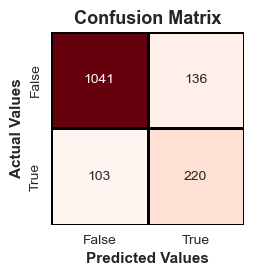


F1-score: 64.80%
Accuracy: 84.07%
Precision: 61.80%
Recall: 68.11%



In [57]:
# Evaluate the best model by adjusting the hyperparameter class weight
model_score(best_model_dict['CatBoost CW'], X_val, y_val)

**By adjusting the hyperparameter `class_weight`, the CatBoost model with a `class_weight` ratio of 1:3 (class 0:class 1) has the highest f1-score of 64.80%.** The recall rate (68.11%) is increased substantially compared to that of the best decision tree model without resampling, which is 44.58%.

[Back to Contents](#back)

### 6.3 Upsampling (Oversampling) <a id='upsampling'></a>

Upsampling the minority class is a common method to deal with the imbalanced classification. The main disadvantage of upsampling method is the increased risk of overfitting due to the duplication of the same samples.

There are different upsampling methods including random oversampling, smote, ADASYN etc. In this project, we will only use the most basic upsampling method, random oversampling.

A balanced ratio of 1:1 in majority and minority classes does not guarantee the best result. We can try to upsampling the minority class with different sampling strategy.

$$\textrm{Sampling Strategy} = \frac {\textrm{Count of Minority Class}}{\textrm{Count of Majority Class}}$$

### 6.3.1 Upsampling the Minority Class with a Sampling Strategy of 0.75

In [58]:
# Upsampling the minority class with a sampling strategy of 0.75
X_train_up1, y_train_up1 = sampling(
    X_train, y_train, sampling_method='up', sampling_strategy=0.75
)

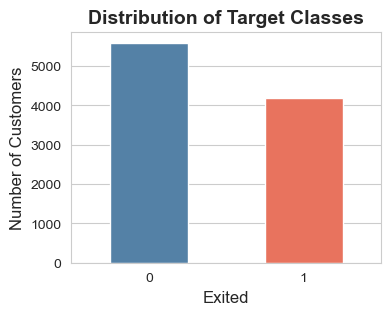

Samples of class 0: 5597
Samples of class 1: 4198
--------------------------------------------------
Percentage of class 0: 57.14%
Percentage of class 1: 42.86%
--------------------------------------------------

The ratio of 0 to 1 is 1.33



In [59]:
# Show the distribution of the target classes with an upsampling strategy of 0.75
target_classes_dist(y_train_up1)

#### Decision Tree

In [60]:
# Find the best decision tree with an upsampling strategy of 0.75
dt_hyperparams = [
    {'criterion': ['gini', 'entropy'],
     'max_depth': [x for x in range(6,16)],}
]

dt_up1_result, best_model_dict['Decision Tree Up 1'], best_model_data_dict['Decision Tree Up 1'] = custom_GridSearch(
    X_train_up1, y_train_up1, X_val, y_val,
    estimator = DecisionTreeClassifier,
    param_grid = dt_hyperparams)

Time taken: 0 minute 1 seconds


In [61]:
# Show the top 10 results
dt_up1_result.head(10)

,criterion,max_depth,f1_score,accuracy
0,entropy,6,0.592297,0.795333
1,gini,7,0.587912,0.800000
2,gini,8,0.584488,0.800000
3,gini,6,0.581957,0.780667
4,entropy,8,0.580913,0.798000
5,entropy,9,0.574616,0.796667
6,entropy,7,0.571805,0.783333
7,gini,9,0.571429,0.802000
8,gini,10,0.565657,0.799333
9,entropy,10,0.547368,0.799333


**By upsampling the minority class with a sampling strategy of 0.75, the best decision tree model has a f1-score of 59.23%**

#### Random Forest

In [62]:
# Find the best random forest with an upsampling strategy of 0.75
rf_hyperparams = [
    {'criterion': ['gini', 'entropy'], 
     'n_estimators': [x for x in range(30,71,10)], 
     'max_depth': [x for x in range(6,11)],}
]

rf_up1_result, best_model_dict['Random Forest Up 1'], best_model_data_dict['Random Forest Up 1'] = custom_GridSearch(
    X_train_up1, y_train_up1, X_val, y_val,
    estimator = RandomForestClassifier,
    param_grid = rf_hyperparams)

Time taken: 0 minute 31 seconds


In [63]:
# Show the top 10 results
rf_up1_result.head(10)

,criterion,n_estimators,max_depth,f1_score,accuracy
0,gini,60,9,0.640379,0.848000
1,gini,30,7,0.638298,0.841333
2,entropy,50,7,0.637462,0.840000
3,gini,50,9,0.637084,0.847333
4,gini,70,7,0.635115,0.840667
5,gini,70,9,0.635071,0.846000
6,gini,30,9,0.634921,0.846667
7,gini,40,9,0.634921,0.846667
8,entropy,60,10,0.634769,0.847333
9,entropy,70,10,0.634615,0.848000


**By upsampling the minority class with a sampling strategy of 0.75, the best random forest model has a f1-score of 64.04%**

#### CatBoost

In [64]:
# Find the best CatBoost with an upsampling strategy of 0.75
cat_hyperparams = [{'iterations': [800],
                    'learning_rate': [0.01, 0.03],
                    'depth': [6, 7],
                    'l2_leaf_reg': [4, 7],
                    'random_strength': [4, 7],
                    'verbose': [False]}]

cat_up1_result, best_model_dict['CatBoost Up 1'], best_model_data_dict['CatBoost Up 1'] = custom_GridSearch(
    X_train_up1, y_train_up1, X_val, y_val,
    estimator = CatBoostClassifier,
    param_grid = cat_hyperparams)

Time taken: 0 minute 55 seconds


In [65]:
# Show the top 10 results
cat_up1_result.head(10)

,iterations,learning_rate,depth,l2_leaf_reg,random_strength,verbose,f1_score,accuracy
0,800,0.03,7,4,4,False,0.646967,0.848667
1,800,0.01,7,4,4,False,0.641452,0.842000
2,800,0.03,6,4,4,False,0.640364,0.842000
3,800,0.03,6,7,7,False,0.640123,0.843333
4,800,0.03,7,7,4,False,0.639752,0.845333
5,800,0.03,7,4,7,False,0.639626,0.846000
6,800,0.03,7,7,7,False,0.636785,0.843333
7,800,0.01,6,4,4,False,0.635682,0.838000
8,800,0.03,6,7,4,False,0.635115,0.840667
9,800,0.03,6,4,7,False,0.634146,0.840000


**By upsampling the minority class with a sampling strategy of 0.75, the best CatBoost model has a f1-score of 64.70%**

### 6.3.2 Upsampling the Minority Class with the Sampling Strategy of 1

In [66]:
# Upsampling the minority class with a sampling strategy of 1
X_train_up2, y_train_up2 = sampling(
    X_train, y_train, sampling_method='up', sampling_strategy=1
)

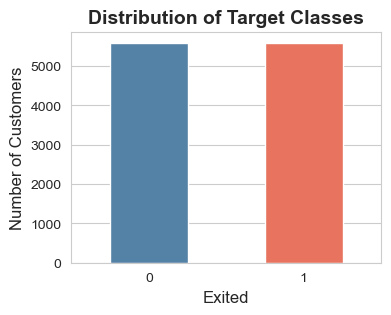

Samples of class 0: 5597
Samples of class 1: 5597
--------------------------------------------------
Percentage of class 0: 50.00%
Percentage of class 1: 50.00%
--------------------------------------------------

The ratio of 0 to 1 is 1.00



In [67]:
# Show the distribution of the target classes with an upsampling strategy of 1
target_classes_dist(y_train_up2)

#### Decision Tree

In [68]:
# Find the best decision tree with an upsampling strategy of 1
dt_hyperparams = [
    {'criterion': ['gini', 'entropy'],
     'max_depth': [x for x in range(6,16)],}
]

dt_up2_result, best_model_dict['Decision Tree Up 2'], best_model_data_dict['Decision Tree Up 2'] = custom_GridSearch(
    X_train_up2, y_train_up2, X_val, y_val,
    estimator = DecisionTreeClassifier,
    param_grid = dt_hyperparams)

Time taken: 0 minute 1 seconds


In [69]:
# Show the top 10 results
dt_up2_result.head(10)

,criterion,max_depth,f1_score,accuracy
0,entropy,7,0.583979,0.785333
1,gini,7,0.581673,0.790000
2,entropy,6,0.579082,0.780000
3,gini,6,0.572840,0.769333
4,entropy,8,0.570270,0.788000
5,gini,9,0.568449,0.779333
6,gini,8,0.565272,0.771333
7,entropy,10,0.561892,0.790000
8,entropy,9,0.553425,0.782667
9,gini,10,0.550279,0.785333


**By upsampling the minority class with a sampling strategy of 1, the best decision tree model has a f1-score of 58.40%**

#### Random Forest

In [70]:
# Find the best random forest with an upsampling strategy of 1
rf_hyperparams = [
    {'criterion': ['gini', 'entropy'], 
     'n_estimators': [x for x in range(30,71,10)], 
     'max_depth': [x for x in range(6,11)],}
]

rf_up2_result, best_model_dict['Random Forest Up 2'], best_model_data_dict['Random Forest Up 2'] = custom_GridSearch(
    X_train_up2, y_train_up2, X_val, y_val,
    estimator = RandomForestClassifier,
    param_grid = rf_hyperparams)

Time taken: 0 minute 34 seconds


In [71]:
# Show the top 10 results
rf_up2_result.head(10)

,criterion,n_estimators,max_depth,f1_score,accuracy
0,gini,70,9,0.640916,0.832667
1,gini,60,9,0.640916,0.832667
2,gini,50,9,0.637807,0.832667
3,gini,30,10,0.636364,0.834667
4,entropy,50,10,0.636364,0.834667
5,entropy,60,10,0.636364,0.834667
6,gini,40,9,0.634783,0.832000
7,entropy,70,10,0.632504,0.832667
8,entropy,60,9,0.629213,0.824000
9,gini,30,9,0.628407,0.827333


**By upsampling the minority class with a sampling strategy of 1, the best random forest model has a f1-score of 64.09%**

#### CatBoost

In [72]:
# Find the best CatBoost with an upsampling strategy of 1
cat_hyperparams = [{'iterations': [800],
                    'learning_rate': [0.01, 0.03],
                    'depth': [6, 7],
                    'l2_leaf_reg': [4, 7],
                    'random_strength': [4, 7],
                    'verbose': [False]}]

cat_up2_result, best_model_dict['CatBoost Up 2'], best_model_data_dict['CatBoost Up 2'] = custom_GridSearch(
    X_train_up2, y_train_up2, X_val, y_val,
    estimator = CatBoostClassifier,
    param_grid = cat_hyperparams)

Time taken: 1 minute 18 seconds


In [73]:
# Show the top 10 results
cat_up2_result.head(10)

,iterations,learning_rate,depth,l2_leaf_reg,random_strength,verbose,f1_score,accuracy
0,800,0.01,7,4,4,False,0.642955,0.826000
1,800,0.01,7,7,4,False,0.640646,0.822000
2,800,0.01,7,4,7,False,0.636856,0.821333
3,800,0.01,7,7,7,False,0.632000,0.816000
4,800,0.03,7,7,7,False,0.631124,0.829333
5,800,0.03,7,7,4,False,0.630814,0.830667
6,800,0.03,6,7,7,False,0.628492,0.822667
7,800,0.03,7,4,7,False,0.627338,0.827333
8,800,0.03,7,4,4,False,0.626996,0.828667
9,800,0.01,6,4,7,False,0.626632,0.809333


**By upsampling the minority class with a sampling strategy of 1, the best CatBoost model has a f1-score of 64.30%**

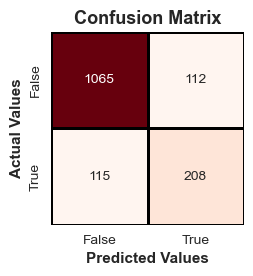


F1-score: 64.70%
Accuracy: 84.87%
Precision: 65.00%
Recall: 64.40%



In [74]:
# Evaluate the best model with upsampling
model_score(best_model_dict['CatBoost Up 1'], X_val, y_val)

**By upsampling the minority class, the CatBoost model with a sampling strategy of 0.75 has the highest f1-score of 64.70%,** which is slight lower than that of the CatBoost model with class weight adjustment.

[Back to Contents](#back)

### 6.4 Downsampling (Undersampling) <a id='downsampling'></a>

Downsampling the majority class is another common method to deal with the imbalanced classification. The main disadvantage of downsampling is the potential loss of information and the model may not have enough samples to learn, resulting in lower performance.

There are different upsampling methods including random undersampling, tomek links, near miss etc. In this project, we will only deploy the most basic downsampling method, random undersampling.

### 6.4.1 Downsampling the Majority Class with the Sampling Strategy of 0.75

In [75]:
# Downsampling the majority class with a sampling strategy of 0.75
X_train_down1, y_train_down1 = sampling(
    X_train, y_train, sampling_method='down', sampling_strategy=0.75
)

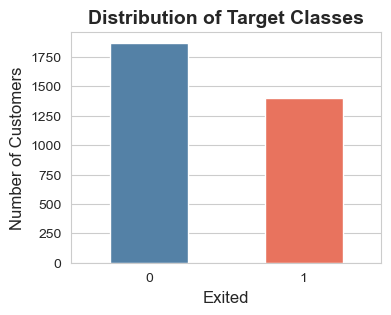

Samples of class 0: 1871
Samples of class 1: 1403
--------------------------------------------------
Percentage of class 0: 57.15%
Percentage of class 1: 42.85%
--------------------------------------------------

The ratio of 0 to 1 is 1.33



In [76]:
# Show the distribution of the target classes with a downsampling strategy of 0.75
target_classes_dist(y_train_down1)

#### Decision Tree

In [77]:
# Find the best decision tree with a downsampling strategy of 0.75
dt_hyperparams = [
    {'criterion': ['gini', 'entropy'],
     'max_depth': [x for x in range(6,16)],}
]

dt_down1_result, best_model_dict['Decision Tree Down 1'], best_model_data_dict['Decision Tree Down 1'] = custom_GridSearch(
    X_train_down1, y_train_down1, X_val, y_val,
    estimator = DecisionTreeClassifier,
    param_grid = dt_hyperparams)

Time taken: 0 minute 1 seconds


In [78]:
# Show the top 10 results
dt_down1_result.head(10)

,criterion,max_depth,f1_score,accuracy
0,gini,6,0.582524,0.799333
1,gini,7,0.567244,0.783333
2,entropy,9,0.562500,0.794667
3,entropy,6,0.560399,0.764667
4,gini,9,0.551451,0.773333
5,gini,8,0.550837,0.767333
6,entropy,7,0.549068,0.758000
7,entropy,8,0.544542,0.758000
8,entropy,11,0.537838,0.772000
9,gini,10,0.534550,0.762000


**By downsampling the majority class with a sampling strategy of 0.75, the best decision tree model has a f1-score of 58.25%**

#### Random Forest

In [79]:
# Find the best random forest with a downsampling strategy of 0.75
rf_hyperparams = [
    {'criterion': ['gini', 'entropy'], 
     'n_estimators': [x for x in range(30,71,10)], 
     'max_depth': [x for x in range(6,11)],}
]

rf_down1_result, best_model_dict['Random Forest Down 1'], best_model_data_dict['Random Forest Down 1'] = custom_GridSearch(
    X_train_down1, y_train_down1, X_val, y_val,
    estimator = RandomForestClassifier,
    param_grid = rf_hyperparams)

Time taken: 0 minute 17 seconds


In [80]:
# Show the top 10 results
rf_down1_result.head(10)

,criterion,n_estimators,max_depth,f1_score,accuracy
0,entropy,40,10,0.632504,0.832667
1,entropy,60,10,0.630015,0.834000
2,entropy,50,10,0.629412,0.832000
3,entropy,60,9,0.628743,0.834667
4,gini,60,6,0.628659,0.839333
5,gini,40,9,0.628319,0.832000
6,entropy,70,9,0.628148,0.832667
7,gini,30,9,0.627043,0.832667
8,entropy,70,8,0.626687,0.834000
9,entropy,70,10,0.626292,0.831333


**By downsampling the majority class with a sampling strategy of 0.75, the best random forest model has a f1-score of 63.25%**

In [81]:
# Find the best CatBoost with a downsampling strategy of 0.75
cat_hyperparams = [{'iterations': [800],
                    'learning_rate': [0.01, 0.03],
                    'depth': [6, 7],
                    'l2_leaf_reg': [4, 7],
                    'random_strength': [4, 7],
                    'verbose': [False]}]

cat_down1_result, best_model_dict['CatBoost Down 1'], best_model_data_dict['CatBoost Down 1'] = custom_GridSearch(
    X_train_down1, y_train_down1, X_val, y_val,
    estimator = CatBoostClassifier,
    param_grid = cat_hyperparams)

Time taken: 0 minute 39 seconds


In [82]:
# Show the top 10 results
cat_down1_result.head(10)

,iterations,learning_rate,depth,l2_leaf_reg,random_strength,verbose,f1_score,accuracy
0,800,0.03,6,7,4,False,0.647727,0.834667
1,800,0.03,6,4,4,False,0.641243,0.830667
2,800,0.03,7,7,4,False,0.639551,0.828667
3,800,0.03,7,4,7,False,0.638655,0.828000
4,800,0.03,6,4,7,False,0.638054,0.831333
5,800,0.01,6,4,7,False,0.635432,0.834000
6,800,0.03,7,4,4,False,0.634697,0.827333
7,800,0.03,6,7,7,False,0.634006,0.830667
8,800,0.01,7,4,4,False,0.632653,0.832000
9,800,0.01,7,7,4,False,0.630814,0.830667


**By downsampling the majority class with a sampling strategy of 0.75, the best CatBoost model has a f1-score of 64.77%**

### 6.4.2 Downsampling the Majority Class with the Sampling Strategy of 1

In [83]:
# Downsampling the majority class with a sampling strategy of 1
X_train_down2, y_train_down2 = sampling(
    X_train, y_train, sampling_method='down', sampling_strategy=1
)

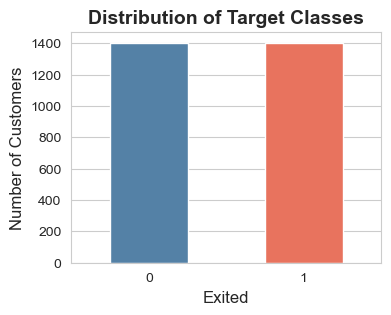

Samples of class 0: 1403
Samples of class 1: 1403
--------------------------------------------------
Percentage of class 0: 50.00%
Percentage of class 1: 50.00%
--------------------------------------------------

The ratio of 0 to 1 is 1.00



In [84]:
# Show the distribution of the target classes with a downsampling strategy of 1
target_classes_dist(y_train_down2)

#### Decision Tree

In [85]:
# Find the best decision tree with a downsampling strategy of 1
dt_hyperparams = [
    {'criterion': ['gini', 'entropy'],
     'max_depth': [x for x in range(6,16)],}
]

dt_down2_result, best_model_dict['Decision Tree Down 2'], best_model_data_dict['Decision Tree Down 2'] = custom_GridSearch(
    X_train_down2, y_train_down2, X_val, y_val,
    estimator = DecisionTreeClassifier,
    param_grid = dt_hyperparams)

Time taken: 0 minute 0 seconds


In [86]:
# Show the top 10 results
dt_down2_result.head(10)

,criterion,max_depth,f1_score,accuracy
0,entropy,7,0.559572,0.780667
1,entropy,10,0.557717,0.772667
2,gini,8,0.556701,0.770667
3,entropy,6,0.555417,0.762000
4,gini,6,0.554102,0.750000
5,entropy,9,0.553729,0.764667
6,entropy,11,0.544554,0.754667
7,entropy,8,0.544135,0.748667
8,gini,7,0.539241,0.757333
9,gini,9,0.530457,0.753333


**By downsampling the majority class with a sampling strategy of 1, the best decision tree model has a f1-score of 55.96%**

#### Random Forest

In [87]:
# Find the best random forest with a downsampling strategy of 1
rf_hyperparams = [
    {'criterion': ['gini', 'entropy'], 
     'n_estimators': [x for x in range(30,71,10)], 
     'max_depth': [x for x in range(6,11)],}
]

rf_down2_result, best_model_dict['Random Forest Down 2'], best_model_data_dict['Random Forest Down 2'] = custom_GridSearch(
    X_train_down2, y_train_down2, X_val, y_val,
    estimator = RandomForestClassifier,
    param_grid = rf_hyperparams)

Time taken: 0 minute 15 seconds


In [88]:
# Show the top 10 results
rf_down2_result.head(10)

,criterion,n_estimators,max_depth,f1_score,accuracy
0,gini,50,10,0.620779,0.805333
1,gini,60,8,0.620237,0.807333
2,gini,30,8,0.619792,0.805333
3,gini,70,8,0.618421,0.806667
4,gini,40,8,0.617188,0.804000
5,gini,50,8,0.616385,0.803333
6,entropy,70,8,0.613368,0.803333
7,gini,70,10,0.612946,0.804667
8,entropy,60,8,0.612352,0.803333
9,entropy,70,9,0.611111,0.804000


**By downsampling the majority class with a sampling strategy of 1, the best random forest model has a f1-score of 62.08%**

#### CatBoost

In [89]:
# Find the best CatBoost with a downsampling strategy of 1
cat_hyperparams = [{'iterations': [800],
                    'learning_rate': [0.01, 0.03],
                    'depth': [6, 7],
                    'l2_leaf_reg': [4, 7],
                    'random_strength': [4, 7],
                    'verbose': [False]}]

cat_down2_result, best_model_dict['CatBoost Down 2'], best_model_data_dict['CatBoost Down 2'] = custom_GridSearch(
    X_train_down2, y_train_down2, X_val, y_val,
    estimator = CatBoostClassifier,
    param_grid = cat_hyperparams)

Time taken: 0 minute 37 seconds


In [90]:
# Show the top 10 results
cat_down2_result.head(10)

,iterations,learning_rate,depth,l2_leaf_reg,random_strength,verbose,f1_score,accuracy
0,800,0.01,6,4,4,False,0.619792,0.805333
1,800,0.01,7,4,4,False,0.619792,0.805333
2,800,0.01,7,4,7,False,0.618370,0.803333
3,800,0.01,7,7,7,False,0.618182,0.804000
4,800,0.03,6,7,7,False,0.616941,0.798000
5,800,0.01,7,7,4,False,0.616580,0.802667
6,800,0.03,6,4,7,False,0.611529,0.793333
7,800,0.03,7,7,4,False,0.610973,0.792000
8,800,0.01,6,7,4,False,0.610390,0.800000
9,800,0.01,6,4,7,False,0.610256,0.797333


**By downsampling the majority class with a sampling strategy of 1, the best CatBoost model has a f1-score of 61.98%**

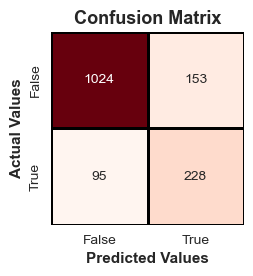


F1-score: 64.77%
Accuracy: 83.47%
Precision: 59.84%
Recall: 70.59%



In [91]:
# Evaluate the best model with downsampling
model_score(best_model_dict['CatBoost Down 1'], X_val, y_val)

**By downsampling the majority class, the CatBoost model with a sampling strategy of 0.75 has the highest f1-score of 64.77%,** which is in between the previous two best models.

[Back to Contents](#back)

### 6.5 Resampling by a Combination of Upsampling and Downsampling (SMOTETomek) <a id='smotetomek'></a>

SMOTE (Synthetic Minority Over-Sampling Technique) creates additional samples by interpolating between samples and corresponding nearest neighbours. 

A Tomek link consists of a pair of samples of differenct classes which are the nearest neighbour of each other. By removing tomek link pairs, it aims to improve the separation between classes, making the decision boundary more distinct.

SMOTETomek is a resampling method combining SMOTE and Tomek links.

### 6.5.1 SMOTETomek with the Sampling Strategy of 0.75

In [92]:
# Resampling by SMOTETomek with a sampling strategy of 0.75
st1 = SMOTETomek(sampling_strategy=0.75, random_state=12345)
X_train_st1, y_train_st1 = st1.fit_resample(X_train, y_train)

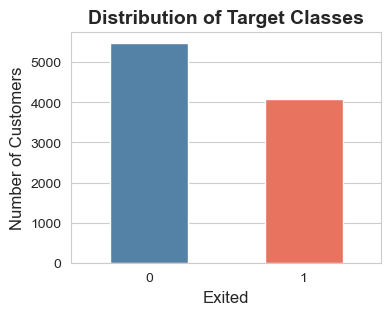

Samples of class 0: 5489
Samples of class 1: 4089
--------------------------------------------------
Percentage of class 0: 57.31%
Percentage of class 1: 42.69%
--------------------------------------------------

The ratio of 0 to 1 is 1.34



In [93]:
# Show the distribution of the target classes by SMOTETomek with a sampling strategy of 0.75
target_classes_dist(y_train_st1)

#### Decision Tree

In [94]:
# Find the best decision tree with a SMOTETomek sampling strategy of 0.75
dt_hyperparams = [
    {'criterion': ['gini', 'entropy'],
     'max_depth': [x for x in range(6,16)],}
]

dt_st1_result, best_model_dict['Decision Tree ST 1'], best_model_data_dict['Decision Tree ST 1'] = custom_GridSearch(
    X_train_st1, y_train_st1, X_val, y_val,
    estimator = DecisionTreeClassifier,
    param_grid = dt_hyperparams)

Time taken: 0 minute 2 seconds


In [95]:
# Show the top 10 results
dt_st1_result.head(10)

,criterion,max_depth,f1_score,accuracy
0,entropy,9,0.605714,0.816000
1,entropy,10,0.603448,0.816000
2,entropy,7,0.600000,0.826667
3,entropy,8,0.599455,0.804000
4,entropy,6,0.594059,0.836000
5,gini,8,0.586742,0.804667
6,gini,7,0.582467,0.812667
7,gini,6,0.581064,0.784667
8,gini,9,0.575758,0.794667
9,gini,11,0.573991,0.810000


**By using SMOTETomek with a sampling strategy of 0.75, the best decision tree model has a f1-score of 60.57%**

#### Random Forest

In [96]:
# Find the best random forest with a SMOTETomek sampling strategy of 0.75
rf_hyperparams = [
    {'criterion': ['gini', 'entropy'], 
     'n_estimators': [x for x in range(30,71,10)], 
     'max_depth': [x for x in range(6,11)],}
]

rf_st1_result, best_model_dict['Random Forest ST 1'], best_model_data_dict['Random Forest ST 1'] = custom_GridSearch(
    X_train_st1, y_train_st1, X_val, y_val,
    estimator = RandomForestClassifier,
    param_grid = rf_hyperparams)

Time taken: 0 minute 44 seconds


In [97]:
# Show the top 10 results
rf_st1_result.head(10)

,criterion,n_estimators,max_depth,f1_score,accuracy
0,entropy,50,8,0.657188,0.855333
1,entropy,60,8,0.651163,0.850000
2,entropy,70,8,0.651017,0.851333
3,entropy,40,8,0.650000,0.850667
4,entropy,60,9,0.646593,0.851333
5,entropy,70,9,0.645570,0.850667
6,entropy,30,6,0.643533,0.849333
7,entropy,30,8,0.642173,0.850667
8,entropy,50,6,0.641975,0.845333
9,gini,30,9,0.640625,0.846667


**By using SMOTETomek with a sampling strategy of 0.75, the best random forest model has a f1-score of 65.72%**

#### CatBoost

In [98]:
# Find the best CatBoost with a SMOTETomek sampling strategy of 0.75
cat_hyperparams = [{'iterations': [800],
                    'learning_rate': [0.01, 0.03],
                    'depth': [6, 7],
                    'l2_leaf_reg': [4, 7],
                    'random_strength': [4, 7],
                    'verbose': [False]}]

cat_st1_result, best_model_dict['CatBoost ST 1'], best_model_data_dict['CatBoost ST 1'] = custom_GridSearch(
    X_train_st1, y_train_st1, X_val, y_val,
    estimator = CatBoostClassifier,
    param_grid = cat_hyperparams)

Time taken: 1 minute 1 seconds


In [99]:
# Show the top 10 results
cat_st1_result.head(10)

,iterations,learning_rate,depth,l2_leaf_reg,random_strength,verbose,f1_score,accuracy
0,800,0.01,6,7,4,False,0.647799,0.850667
1,800,0.01,6,4,4,False,0.645669,0.850000
2,800,0.03,7,7,4,False,0.643234,0.864667
3,800,0.03,6,7,7,False,0.640845,0.864000
4,800,0.03,7,4,7,False,0.639719,0.863333
5,800,0.01,7,7,4,False,0.639110,0.848667
6,800,0.03,7,7,7,False,0.638596,0.862667
7,800,0.03,6,4,7,False,0.638298,0.864000
8,800,0.03,6,7,4,False,0.638298,0.864000
9,800,0.03,7,4,4,False,0.637478,0.862000


**By using SMOTETomek with a sampling strategy of 0.75, the best random forest model has a f1-score of 64.78%**

### 6.5.2 SMOTETomek with the Sampling Strategy of 0.75

In [100]:
# Resampling by SMOTETomek with a sampling strategy of 1
st2 = SMOTETomek(sampling_strategy=1, random_state=12345)
X_train_st2, y_train_st2 = st2.fit_resample(X_train, y_train)

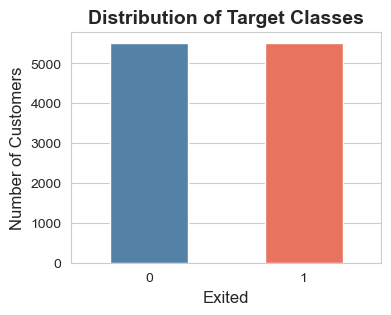

Samples of class 0: 5519
Samples of class 1: 5519
--------------------------------------------------
Percentage of class 0: 50.00%
Percentage of class 1: 50.00%
--------------------------------------------------

The ratio of 0 to 1 is 1.00



In [101]:
# Show the distribution of the target classes by SMOTETomek with a sampling strategy of 1
target_classes_dist(y_train_st2)

#### Decision Tree

In [102]:
# Find the best decision tree with a SMOTETomek sampling strategy of 1
dt_hyperparams = [
    {'criterion': ['gini', 'entropy'],
     'max_depth': [x for x in range(6,16)],}
]

dt_st2_result, best_model_dict['Decision Tree ST 2'], best_model_data_dict['Decision Tree ST 2'] = custom_GridSearch(
    X_train_st2, y_train_st2, X_val, y_val,
    estimator = DecisionTreeClassifier,
    param_grid = dt_hyperparams)

Time taken: 0 minute 2 seconds


In [103]:
# Show the top 10 results
dt_st2_result.head(10)

,criterion,max_depth,f1_score,accuracy
0,gini,9,0.615165,0.820667
1,gini,10,0.597260,0.804000
2,gini,8,0.592992,0.798667
3,gini,11,0.585366,0.807333
4,entropy,6,0.582619,0.772667
5,entropy,8,0.581673,0.790000
6,entropy,11,0.581560,0.803333
7,entropy,9,0.579495,0.811333
8,gini,7,0.577320,0.781333
9,entropy,10,0.577143,0.802667


**By using SMOTETomek with a sampling strategy of 1, the best decision tree model has a f1-score of 61.52%**

#### Random Forest

In [104]:
# Find the best random forest with a SMOTETomek sampling strategy of 1
rf_hyperparams = [
    {'criterion': ['gini', 'entropy'], 
     'n_estimators': [x for x in range(30,71,10)], 
     'max_depth': [x for x in range(6,11)],}
]

rf_st2_result, best_model_dict['Random Forest ST 2'], best_model_data_dict['Random Forest ST 2'] = custom_GridSearch(
    X_train_st2, y_train_st2, X_val, y_val,
    estimator = RandomForestClassifier,
    param_grid = rf_hyperparams)

Time taken: 0 minute 54 seconds


In [105]:
# Show the top 10 results
rf_st2_result.head(10)

,criterion,n_estimators,max_depth,f1_score,accuracy
0,entropy,60,9,0.646199,0.838667
1,entropy,70,9,0.642336,0.836667
2,gini,70,8,0.638537,0.828667
3,entropy,60,10,0.638235,0.836000
4,gini,40,10,0.638235,0.836000
5,gini,70,10,0.637555,0.834000
6,gini,60,10,0.637427,0.834667
7,entropy,70,10,0.635015,0.836000
8,entropy,50,9,0.634921,0.831333
9,gini,60,8,0.634697,0.827333


**By using SMOTETomek with a sampling strategy of 1, the best random forest model has a f1-score of 64.62%**

#### CatBoost

In [106]:
# Find the best CatBoost with a SMOTETomek sampling strategy of 1
cat_hyperparams = [{'iterations': [800],
                    'learning_rate': [0.01, 0.03],
                    'depth': [6, 7],
                    'l2_leaf_reg': [4, 7],
                    'random_strength': [4, 7],
                    'verbose': [False]}]

cat_st2_result, best_model_dict['CatBoost ST 2'], best_model_data_dict['CatBoost ST 2'] = custom_GridSearch(
    X_train_st2, y_train_st2, X_val, y_val,
    estimator = CatBoostClassifier,
    param_grid = cat_hyperparams)

Time taken: 1 minute 27 seconds


In [107]:
# Show the top 10 results
cat_st2_result.head(10)

,iterations,learning_rate,depth,l2_leaf_reg,random_strength,verbose,f1_score,accuracy
0,800,0.01,6,4,4,False,0.652047,0.841333
1,800,0.01,7,4,4,False,0.649926,0.842000
2,800,0.03,6,7,7,False,0.648276,0.864000
3,800,0.01,6,7,4,False,0.648256,0.838667
4,800,0.03,7,7,4,False,0.648180,0.864667
5,800,0.01,7,7,4,False,0.648094,0.840000
6,800,0.03,7,7,7,False,0.647160,0.863333
7,800,0.03,6,4,4,False,0.647059,0.864000
8,800,0.03,6,4,7,False,0.643718,0.862000
9,800,0.01,7,7,7,False,0.642651,0.834667


**By using SMOTETomek with a sampling strategy of 1, the best CatBoost model has a f1-score of 65.20%**

 RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=50,
                       random_state=12345) 


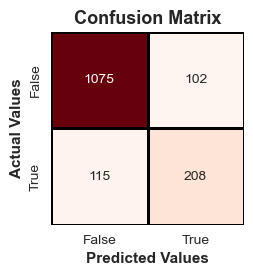


F1-score: 65.72%
Accuracy: 85.53%
Precision: 67.10%
Recall: 64.40%



In [108]:
# Evaluate the best model with SMOTETomek
model_score(best_model_dict['Random Forest ST 1'], X_val, y_val)

**By using SMOTETomek resampling method, the random forest model with a sampling strategy of 0.75 has the highest f1-score of 65.72%,** which is also the highest score among all models.

[Back to Contents](#back)

## 7. Final Model Selection and Evaluation <a id='final_model'></a>

In [109]:
# Create two lists containing the information of best models
best_model_type = []
best_model_data = []

for classifier_type, classifier_data in best_model_data_dict.items():
    best_model_type.append(classifier_type)
    best_model_data.append(classifier_data)

# Create a dataframe containing all the best models and the accuracies
best_model_df = pd.DataFrame({'model': best_model_type, 'data': best_model_data})
best_model_df = pd.concat([best_model_df['model'], pd.json_normalize(best_model_df['data'], max_level=0)], axis=1)
best_model_df = best_model_df.sort_values('f1_score', ascending=False).reset_index(drop=True)

# Have a look at the dataframe
best_model_df

,model,class_0,class_1,hyperparameters,f1_score,accuracy
0,Random Forest ST 1,5489,4089,"{'criterion': 'entropy', 'n_estimators': 50, '...",0.657188,0.855333
1,CatBoost ST 2,5519,5519,"{'iterations': 800, 'learning_rate': 0.01, 'de...",0.652047,0.841333
2,CatBoost CW,5597,1403,"{'iterations': 800, 'learning_rate': 0.01, 'de...",0.648012,0.840667
3,CatBoost ST 1,5489,4089,"{'iterations': 800, 'learning_rate': 0.01, 'de...",0.647799,0.850667
4,CatBoost Down 1,1871,1403,"{'iterations': 800, 'learning_rate': 0.03, 'de...",0.647727,0.834667
5,CatBoost Up 1,5597,4198,"{'iterations': 800, 'learning_rate': 0.03, 'de...",0.646967,0.848667
6,Random Forest ST 2,5519,5519,"{'criterion': 'entropy', 'n_estimators': 60, '...",0.646199,0.838667
7,Random Forest CW,5597,1403,"{'criterion': 'entropy', 'n_estimators': 60, '...",0.645265,0.852667
8,CatBoost Up 2,5597,5597,"{'iterations': 800, 'learning_rate': 0.01, 'de...",0.642955,0.826000
9,Random Forest Up 2,5597,5597,"{'criterion': 'gini', 'n_estimators': 60, 'max...",0.640916,0.832667


The f1-scores of the top five models are very close. Therefore, 5-fold cross validation will be performed to have more precise f1-scores. The model with the highest mean f1-score in the 5-fold corss validation will be selected as the final model.

In [110]:
# Create a function to perform the 5-fold cross validation
def calc_cv_f1_score(model, model_name, X_train, y_train):
    """
    This function performs 5-fold cross validation on each model
    and return the mean of the 5 accuracy scores
    """          
    f1_scores = cross_val_score(model[model_name], X=X_train, y=y_train, 
                                scoring='f1', cv=5, n_jobs=-1)
    
    return f1_scores.mean()

In [111]:
# Apply the function to find the mean of 5-fold cross validation f1-scores
best_model_df['cv_f1_score'] = best_model_df['model'].apply(
    lambda x: calc_cv_f1_score(best_model_dict, x, X_train_val, y_train_val)
)

In [112]:
# Check the 5-fold cross validation result
best_model_df = best_model_df.sort_values('cv_f1_score', ascending=False).reset_index(drop=True)
best_model_df

,model,class_0,class_1,hyperparameters,f1_score,accuracy,cv_f1_score
0,CatBoost CW,5597,1403,"{'iterations': 800, 'learning_rate': 0.01, 'de...",0.648012,0.840667,0.619711
1,Random Forest CW,5597,1403,"{'criterion': 'entropy', 'n_estimators': 60, '...",0.645265,0.852667,0.605251
2,CatBoost Up 1,5597,4198,"{'iterations': 800, 'learning_rate': 0.03, 'de...",0.646967,0.848667,0.585153
3,CatBoost Down 1,1871,1403,"{'iterations': 800, 'learning_rate': 0.03, 'de...",0.647727,0.834667,0.584719
4,Decision Tree CW,5597,1403,"{'criterion': 'entropy', 'max_depth': 8, 'clas...",0.617691,0.830000,0.571376
5,CatBoost Up 2,5597,5597,"{'iterations': 800, 'learning_rate': 0.01, 'de...",0.642955,0.826000,0.568077
6,CatBoost ST 1,5489,4089,"{'iterations': 800, 'learning_rate': 0.01, 'de...",0.647799,0.850667,0.565823
7,CatBoost ST 2,5519,5519,"{'iterations': 800, 'learning_rate': 0.01, 'de...",0.652047,0.841333,0.563731
8,CatBoost Down 2,1403,1403,"{'iterations': 800, 'learning_rate': 0.01, 'de...",0.619792,0.805333,0.563731
9,Random Forest Down 2,1403,1403,"{'criterion': 'gini', 'n_estimators': 50, 'max...",0.620779,0.805333,0.549055


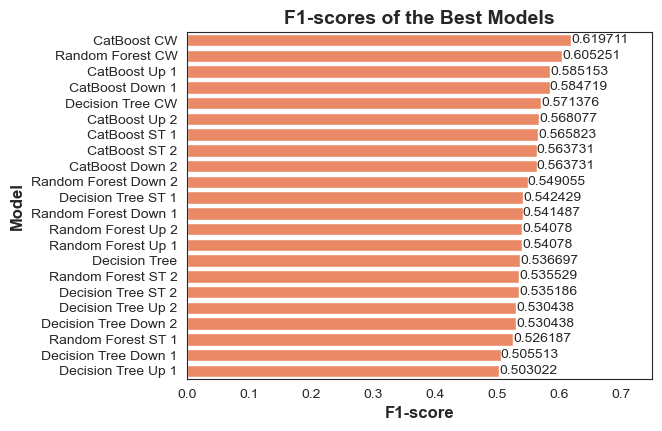

In [113]:
# Plot a barchart to visualise the f1-scores of the model
sns.set_style('white')
plt.figure(figsize=(6,4.5))

ax = sns.barplot(data=best_model_df, x='cv_f1_score', y='model', color='coral')

ax.set_title('F1-scores of the Best Models', fontsize=14, fontweight='bold')
ax.set_xlabel('F1-score', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')

for i in ax.containers:
    ax.bar_label(i, )
    
ax.set_xlim(0, 0.75)

plt.show()

Generally, the models with hyperparameter `class_weight` adjustment have higher f1-scores while the models with downsampling method have lower f1-scores.

**The CatBoost model with `class_weight` adjustment has the highest cross validation f1 score of 61.98% and thus will be selected as the final model.**

[Back to Contents](#back)

### 7.1 Threshold Adjustment <a id='threshold'></a>

The default threshold of a classifier is set to 0.5, by adjusting the threshold, it is possible to achieve a higher f1-score. However, this may results in changes to accuracy, precision or recall. The choice of threshold adjustment should be based on the specific requirements of the situation. In this project, threshold adjustment will be performed to meet Beta Bank's request of developing a model with the best possible f1-score.

In [114]:
# Assign the CatBoost CW as the final model
final_model = best_model_dict['CatBoost CW']

In [115]:
# Grid search the threshold of best f1-score
best_f1 = 0
best_threshold = 0
y_val_scores = final_model.predict_proba(X_val)[:,1]

for threshold in np.arange(0, 1.01, 0.01):
    pred = (y_val_scores >= threshold).astype('int')
    f1 = f1_score(y_val, pred)    
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print('\033[1m')
print('Best f1-score:', best_f1)
print('Best threshold:', best_threshold)
print('\033[0m')


Best f1-score: 0.6517571884984026
Best threshold: 0.55



[Back to Contents](#back)

### 7.2 F1-score, Precision and Recall <a id='metrics'></a>

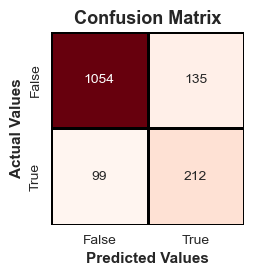


F1-score: 64.44%
Accuracy: 84.40%
Precision: 61.10%
Recall: 68.17%



In [116]:
# Evaluate the final model without threshold adjustment
model_score(final_model, X_test, y_test)

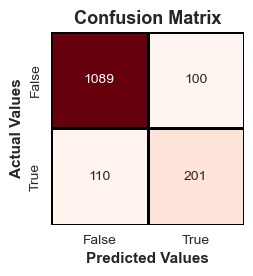


F1-score: 65.69%
Accuracy: 86.00%
Precision: 66.78%
Recall: 64.63%



In [117]:
# Evaluate the final model by setting threshold at 0.55
model_score(final_model, X_test, y_test, threshold=0.55)

Before adjusting the threshold, the f1-score of the final model is 64.44%.

**After setting the threshold at 0.55, the f1-score of the final model is 65.69%. The precision and accuracy are also increased while the recall is decreased.**

In [118]:
# print the classification report
y_scores = final_model.predict_proba(X_test)[:,1]
y_pred = (y_scores >= 0.55).astype(int)

print('Classification Report')
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1189
           1       0.67      0.65      0.66       311

    accuracy                           0.86      1500
   macro avg       0.79      0.78      0.78      1500
weighted avg       0.86      0.86      0.86      1500



From the classification report, it can be seen that the model performs better at predicting the `0` class (customer who stays), with a f1-score of 91%. The f1-score of the `1` class (customers who left) is 66%.

Since the objective of Beta Bank is to retain the customers who might leave, the evaluation on the `1` class is more important.
The precision for the `1` class is 67% while the recall is 65%, this result is above average but could be better.

Since the target variable has an imbalanced classes of 80:20, this could be one of the reasons that the model is not great at predicting the `1` class. This can be verified by the slightly higher weighted avg scores than the macro avg scores.

[Back to Contents](#back)

### 7.3 ROC Curve and AUC-ROC Score <a id='auc_roc'></a>

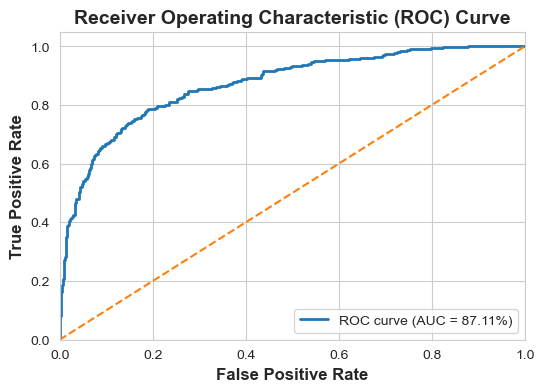

In [119]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate the AUC-ROC score
roc_auc = roc_auc_score(y_test, y_scores)

# Plot the ROC curve
sns.set_style('whitegrid')
plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2%})')
plt.plot([0, 1], [0, 1], ls='--')

plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')

plt.show()

**A AUC-ROC score of 87.11% implies that the model can generally be considered as a good model.**

**Possible Improvement on the Model**

1. Try other resampling techniques, for example, near miss, kmeans smote etc.
2. Collect more data in minority class.
3. Experiment with other machine learning models like KNN, SVM. Also consider boosting and stacking ensemble learning.

[Back to Contents](#back)

## 8.0 General Conclusion <a id='general_conclusion'></a>

**Data Exploration**

In this stage, some issues have been identified as follows:
- The `RowNumber`, `CustomerId` and `Surname` should be dropped. 
- The categorical features `Geography` and `Gender` should be transformed into numerical features. 
- The `Tenure` column has 909 missing values.
- The ranges of the values of the numerical features are of different scales and feature scaling will be applied

**Data Preprocessing**
- The `RowNumber`, `CustomerId` and `Surname` have been dropped. 
- Fill the missing values in the `tenure` column with random samples.

**Exploratory Data Analysis**

- The distributions of data of `credit_score` and `age` data is skewed. Log transformation will be applied to these two columns to make the data distribution closer to a normal disbution.
- `age`, `balance`, `geography`, `gender`, `num_of_products` and `is_active_member` are potential good indicators for model to predict whether a customer will leave.

**Feature Engineering**
- Transform `geography` with label encoder and `Gender` with one-hot encoder. 
- Log transformation has been applied onto the `credit_score` and `age` features.
- Standardisation has been applied on the numerical features.

**Development and Fine Tuning of Different Models**

A total of 22 machine learning models have been developed, consists of `decision tree`, `random forest`, and `CatBoost` models.
Three different sampling techniques have been applied:
- Class weight adjustment within the model.
- Upsampling: Two sampling strategies of 0.75 and 1 have been applied.
- Downsampling: Two sampling strategies of 0.75 and 1 have been applied.
- SMOTETomek: Two sampling strategies of 0.75 and 1 have been applied.

**Selecting the Final Model**

After conducting a 5-fold cross validation, **the CatBoost model with class weight adjustment has the highest cross validation f1-score of 61.98%** and is selected as the final model. **The f1-score of the CatBoost model after threshold adjustment achieve a f1-score of 65.69% on the test set** which meets the expectation of Beta Bank

**A ROC-AUC score of 87.11% indicating that the model is considered as a good model.**

**Possible Improvement on the Model**

1. Try other resampling techniques, for example, near miss, kmeans smote etc.
2. Collect more data in minority class.
3. Experiment with other machine learning models like KNN, SVM. Also consider boosting and stacking ensemble learning.

[Back to Contents](#back)